<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/VGG16_kaggle_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# install libraries

# suppress output
%%capture 

!pip install rasterio
!pip install geopandas
!pip install sentinelsat
!pip install satpy
!pip install glymur
!pip install python-geotiepoints
!pip install pyspectral
!pip install progressbar2
!pip install kaggle
!pip install tifffile

In [2]:
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [0]:
# Base dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
import rasterio as rio # raster spatial operations
import json

# Plotting
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import matplotlib.pyplot as plt

#Sentinel-2 I/O
from sentinelsat import SentinelAPI
from satpy.scene import Scene
from satpy import find_files_and_readers
import requests, zipfile, io, os, shutil # downloading and extracting zipfolders

# Sentinel-2 create patches
from shapely.geometry import Point # vector geometries
import time
import progressbar

# Resize Kaggle patches
from skimage.transform import resize
import tifffile as tiff
import scipy.ndimage


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Functions
credit to # https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordinates

In [0]:
# Extracts RGB 3-channel image from SAFE directory and saves it in the working directory 
# and returns the path to the new file
def extract_rgb_jp2(safePath, sceneTitle):
  for subdirs, dirs, files in os.walk(safePath):
    for file in files:
      if file.endswith('_TCI.jp2'):
        rgbPath = os.path.join(subdirs, file)
        destPath = sceneTitle+'.jp2'
        print(f'Copying {file} to {destPath}')
        shutil.copy2(rgbPath, destPath)
        return destPath

In [0]:
# returns matrix of [n ships, patch_size, patch_size]
def create_ship_patches(ships, img, patch_size=50):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      patch = img.read(window=window) # clip is a nbands * patch_size * patch_size numpy array
      patch_list[i] = np.transpose(patch, (1,2,0)) # transpose to [patch_size, patch_size, n bands]
      bar.update(i)
  return patch_list.astype(int)

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size)) * len(range(0,img.width, step_size))
  patch_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_list.append(np.transpose(patch, (1,2,0))) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.stack(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_buffers(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))
  isShip_list = [] #list to hold all the patch locations
  buffer_list = []
  x_list = []
  y_list = []
  index = 0

  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          #create centroid point
          centroid = Point(img.transform *(window.col_off+patch_size/2, window.row_off+patch_size/2))
          buffer = centroid.buffer(img.transform[0]*step_size/1.5)
          buffer_list.append(buffer)
          isShip = np.any(ships.intersects(buffer)) #intersect ships with polygon and check if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# plots a patch
def plot_patch(img, x, y, patch_size=50, step_size=30):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window)
  show(patch, title=f'x: {x}, y: {y}')

# Define Parameters

In [0]:
DRIVE_PATH = '/content/drive/My Drive/MUSA-650-Final-Project/'

In [0]:
#Load param file
with open(DRIVE_PATH+'params.json', 'r') as file:
    params = json.load(file)
    
    SENTINEL_USER = params['SENTINEL_USER']
    SENTINEL_PWD = params['SENTINEL_PWD']
    KAGGLE_USER = params['KAGGLE_USER']
    KAGGLE_KEY = params['KAGGLE_KEY']

In [0]:
# unique Sentinel-2 tile id for images covering Singapore
TILE_ID = "48NUG" 

In [0]:
# Patch parameters
PATCH_SIZE = 24
STEP_SIZE = 12
SCALE_FACTOR = 4/10 #PlanetScope GSD / Sentinel-2 GSD

# Download Data

## Kaggle PlanetScope

In [14]:
os.mkdir('.kaggle')
os.listdir()

['.config', 'drive', '.kaggle', 'sample_data']

In [0]:
token = {"username":KAGGLE_USER,"key":KAGGLE_KEY}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [16]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
- path is now set to: {/content}


In [17]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery -p /content

 98% 181M/185M [00:05<00:00, 52.7MB/s]
100% 185M/185M [00:05<00:00, 37.9MB/s]


In [18]:
os.listdir()

['.config',
 'drive',
 '.kaggle',
 'ships-in-satellite-imagery.zip',
 'sample_data']

In [0]:
with zipfile.ZipFile('ships-in-satellite-imagery.zip', 'r') as kaggleZip:
      kaggleZip.extractall(os.getcwd())

In [0]:
# with open('shipsnet.json') as data_file:
#     kg_ships_df = pd.DataFrame(json.load(data_file))
# print(kg_ships_df.shape)
# kg_ships_df.head()

In [21]:
with open('shipsnet.json') as data_file:
    kg_ships_dict = json.load(data_file)

kg_ships_df = pd.DataFrame(kg_ships_dict)
kg_ships_df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [22]:
n_spectrum = 3 # color channel (RGB)
kg_patch_size = 80
kg_ships_patches = np.array(kg_ships_dict['data']
             ).astype('uint8'
             ).reshape([-1, n_spectrum, kg_patch_size, kg_patch_size])
kg_ships_patches = np.moveaxis(kg_ships_patches, 1, 3)
kg_ships_patches.shape

(4000, 80, 80, 3)

In [23]:
kg_ships_patches.min(), kg_ships_patches.max()

(1, 255)

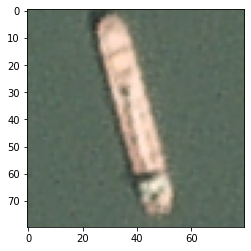

In [24]:
plt.imshow(kg_ships_patches[100])

In [0]:
kg_patch_new_size = round(kg_patch_size*SCALE_FACTOR)

kg_patches_resize = np.zeros([kg_ships_patches.shape[0],
                            kg_patch_new_size,
                            kg_patch_new_size,
                            kg_ships_patches.shape[3]])

In [0]:
for img in range(kg_ships_patches.shape[0]):
  kg_patches_resize[img] = resize(kg_ships_patches[img], [kg_patch_new_size, kg_patch_new_size])

((4000, 32, 32, 3), <matplotlib.image.AxesImage at 0x7f6d04b64208>)

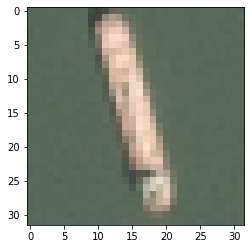

In [27]:
kg_patches_resize.shape, plt.imshow(kg_patches_resize[100])

In [29]:
kg_ships_df.labels[100]

1

In [0]:
# Sample data
from sklearn.model_selection import train_test_split
X_data, X_sample, y_data, y_sample = train_test_split(kg_patches_resize, 
                                                    kg_ships_df.labels, 
                                                    stratify=kg_ships_df.labels, 
                                                    test_size=0.5, 
                                                    random_state=42)

In [32]:
X_sample.shape

(2000, 32, 32, 3)

1


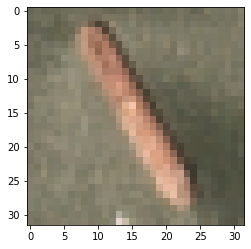

In [47]:
print(y_data[9])
plt.imshow(X_data[9]);

In [0]:
### IS THERE A REASON WE NEED TO LIMIT THE KAGGLE DATA?


#Prepare Data
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

x_train, x_test, y_train, y_test = train_test_split(X_sample, 
                                                    y_sample, 
                                                    stratify=y_sample, 
                                                    test_size=0.5, 
                                                    random_state=42)
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([750, 250])), (array([0, 1]), array([750, 250])))

In [48]:
#Prepare Data
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

x_train, x_test, y_train, y_test = train_test_split(kg_patches_resize, 
                                                    kg_ships_df.labels, 
                                                    stratify=kg_ships_df.labels, 
                                                    test_size=0.5, 
                                                    random_state=42)
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

Using TensorFlow backend.


((array([0, 1]), array([1500,  500])), (array([0, 1]), array([1500,  500])))

1


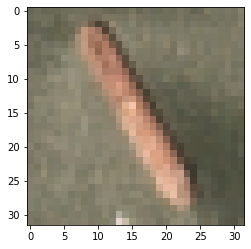

In [49]:
print(y_train[9])
plt.imshow(x_train[9]);

In [59]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = y_train.astype('int')
y_test = y_test.astype('int')
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes, dtype='int')
y_test = keras.utils.to_categorical(y_test, num_classes, dtype='int')

2000 train samples
2000 test samples


In [0]:
x_train.shape

(2000, 32, 32, 3)

In [0]:
y_train

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [0]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Activation

input_shape=x_train.shape[1:]

M = Sequential()
M.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
M.add(MaxPooling2D(pool_size=(2, 2))) #12x12
M.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
M.add(MaxPooling2D(pool_size=(2, 2))) #12x12
M.add(Dropout(0.20))

M.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
M.add(MaxPooling2D(pool_size=(2, 2))) #6x6

#M.add(Conv2D(512, (3, 3), padding='same', activation='softmax'))
#M.add(MaxPooling2D(pool_size=(2, 2))) #3x3

# M.add(Dropout(0.20))
M.add(Flatten())

M.add(Dense(512, activation='relu'))
# M.add(Dropout(0.40))
#M.add(Dense(512, activation='softmax'))
M.add(Dense(2, activation='sigmoid'))

In [52]:
M.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)             

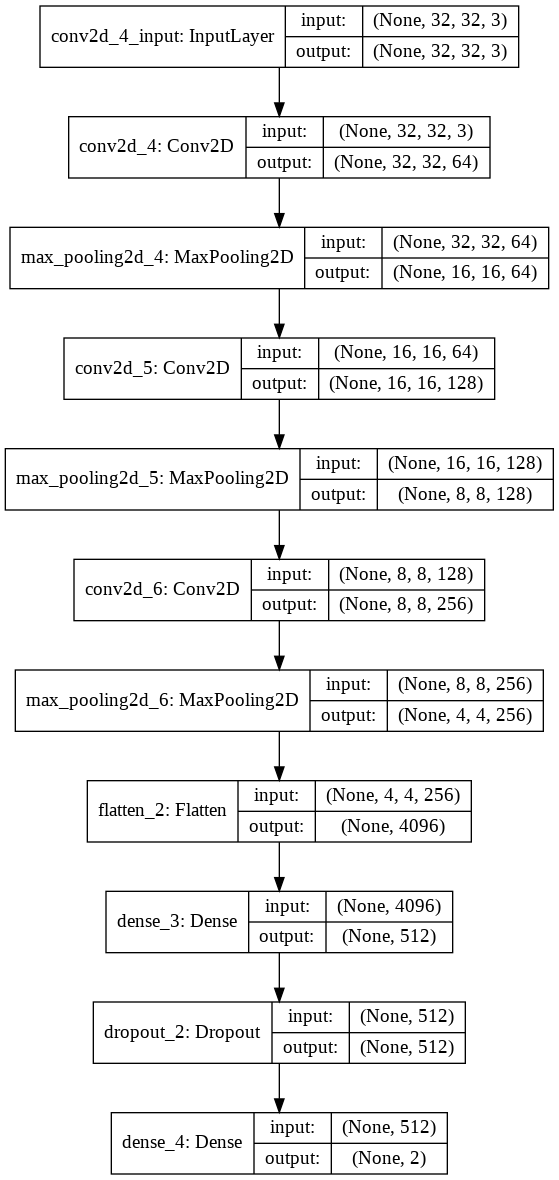

In [53]:
from keras.utils import plot_model

plot_model(M, show_shapes=True, show_layer_names=True)

In [0]:
from keras.optimizers import SGD
opt = SGD(lr=0.01)

M.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=128,
    )

validation_generator = test_datagen.flow(
    x_test,
    y_test,
    batch_size=128,
    )

history = M.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)

Epoch 1/100
15/15 [==============================] - 1s 51ms/step - loss: 0.3624 - accuracy: 0.8210 - val_loss: 0.3956 - val_accuracy: 0.8260
Epoch 2/100
15/15 [==============================] - 1s 56ms/step - loss: 0.3516 - accuracy: 0.8273 - val_loss: 0.3417 - val_accuracy: 0.8173
Epoch 3/100
15/15 [==============================] - 1s 54ms/step - loss: 0.3414 - accuracy: 0.8306 - val_loss: 0.3237 - val_accuracy: 0.8411
Epoch 4/100
15/15 [==============================] - 1s 55ms/step - loss: 0.3248 - accuracy: 0.8422 - val_loss: 0.3679 - val_accuracy: 0.8176
Epoch 5/100
15/15 [==============================] - 1s 48ms/step - loss: 0.3284 - accuracy: 0.8494 - val_loss: 0.2602 - val_accuracy: 0.8595
Epoch 6/100
15/15 [==============================] - 1s 55ms/step - loss: 0.3309 - accuracy: 0.8488 - val_loss: 0.2601 - val_accuracy: 0.8544
Epoch 7/100
15/15 [==============================] - 1s 48ms/step - loss: 0.3033 - accuracy: 0.8539 - val_loss: 0.3183 - val_accuracy: 0.8673
Epoch 

In [65]:
#Evaluating test loss and test accuracy
score = M.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07054419852700085
Test accuracy: 0.9792500138282776


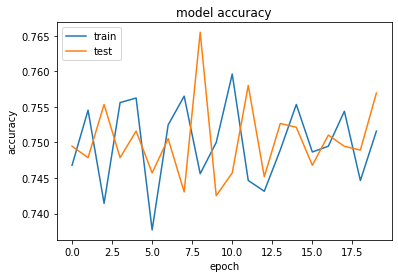

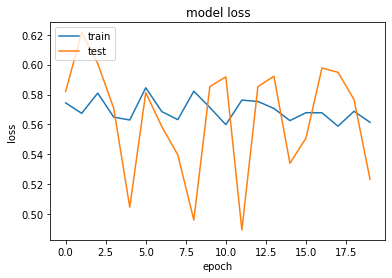

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:

datagen = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs)

# VGG16

In [0]:
from keras.applications import vgg16

In [67]:
conv_base = vgg16.VGG16(include_top=False,
            input_shape = input_shape)

conv_base.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [68]:
# how many weights are trainable in the VGG16 model?
len(conv_base.trainable_weights)

26

In [0]:
# freeze the weights
for layer in conv_base.layers:
  layer.trainable = False

In [70]:
# now there are 0
len(conv_base.trainable_weights)

0

In [0]:
model_file = DRIVE_PATH + 'models/M2.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [80]:
M2 = Sequential()

M2.add(conv_base)

M2.add(Flatten())
M2.add(Dense(512, activation='relu'))
M2.add(Dropout(0.2))
M2.add(Dense(2, activation='sigmoid'))

M2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


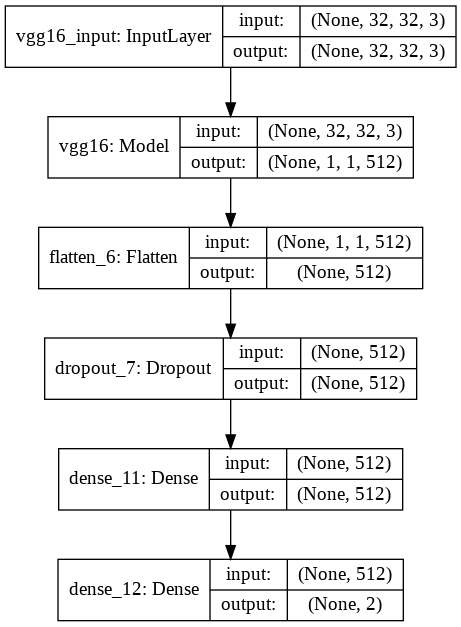

In [77]:
plot_model(M2, show_shapes=True, show_layer_names=True)

In [0]:
M2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [82]:
history = M2.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)

Epoch 1/100
15/15 [==============================] - 1s 55ms/step - loss: 0.6116 - accuracy: 0.7193 - val_loss: 0.5445 - val_accuracy: 0.7500
Epoch 2/100
15/15 [==============================] - 1s 57ms/step - loss: 0.5681 - accuracy: 0.7553 - val_loss: 0.5711 - val_accuracy: 0.7468
Epoch 3/100
15/15 [==============================] - 1s 57ms/step - loss: 0.5709 - accuracy: 0.7495 - val_loss: 0.5360 - val_accuracy: 0.7500
Epoch 4/100
15/15 [==============================] - 1s 57ms/step - loss: 0.5690 - accuracy: 0.7479 - val_loss: 0.5673 - val_accuracy: 0.7495
Epoch 5/100
15/15 [==============================] - 1s 50ms/step - loss: 0.5724 - accuracy: 0.7489 - val_loss: 0.5869 - val_accuracy: 0.7473
Epoch 6/100
15/15 [==============================] - 1s 50ms/step - loss: 0.5678 - accuracy: 0.7490 - val_loss: 0.5573 - val_accuracy: 0.7575
Epoch 7/100
15/15 [==============================] - 1s 57ms/step - loss: 0.5616 - accuracy: 0.7596 - val_loss: 0.5269 - val_accuracy: 0.7511
Epoch 

In [0]:
score = M2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.566182641506195
Test accuracy: 0.75


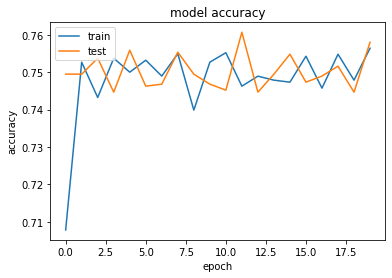

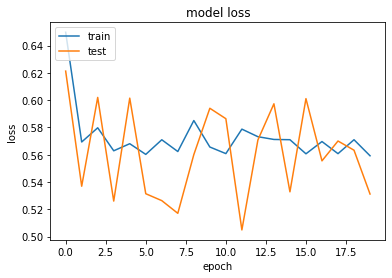

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# unfreeze the latter 2/3ds of the base
for layer in conv_base.layers[7:]:
  layer.trainable = True

In [0]:
len(conv_base.trainable_weights)

18

In [0]:
from keras.optimizers import adam

In [0]:
# set a lower learning rate to minimize magnitude of changes to weights
M2.compile(loss='binary_crossentropy',
              optimizer=adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [0]:
history = M2.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)

Epoch 1/20
15/15 [==============================] - 2s 107ms/step - loss: 0.5733 - accuracy: 0.7500 - val_loss: 0.5638 - val_accuracy: 0.7484
Epoch 2/20
15/15 [==============================] - 1s 84ms/step - loss: 0.5602 - accuracy: 0.7569 - val_loss: 0.5603 - val_accuracy: 0.7500
Epoch 3/20
15/15 [==============================] - 1s 84ms/step - loss: 0.5768 - accuracy: 0.7404 - val_loss: 0.5531 - val_accuracy: 0.7511
Epoch 4/20
15/15 [==============================] - 1s 78ms/step - loss: 0.5723 - accuracy: 0.7431 - val_loss: 0.5352 - val_accuracy: 0.7516
Epoch 5/20
15/15 [==============================] - 1s 77ms/step - loss: 0.5559 - accuracy: 0.7568 - val_loss: 0.5162 - val_accuracy: 0.7527
Epoch 6/20
15/15 [==============================] - 1s 78ms/step - loss: 0.5574 - accuracy: 0.7522 - val_loss: 0.5902 - val_accuracy: 0.7479
Epoch 7/20
15/15 [==============================] - 1s 77ms/step - loss: 0.5735 - accuracy: 0.7441 - val_loss: 0.5648 - val_accuracy: 0.7457
Epoch 8/20
1

In [0]:
score = M2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5722294955253601
Test accuracy: 0.75


In [0]:
model_file = DRIVE_PATH + 'models/M3.h5'

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [0]:
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = adam(learning_rate=1e-4)
lr_metric = get_lr_metric(optimizer)

In [0]:
M3 = Sequential()

M3.add(conv_base)

M3.add(Flatten())
M3.add(Dropout(0.5))
M3.add(Dense(512, activation='relu'))
M3.add(Dense(2, activation='sigmoid'))

M3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 14,718,210
Non-trainable params: 260,160
_________________________________________________________________


In [0]:
M3.compile(loss='binary_crossentropy',
              optimizer=adam(learning_rate=1e-4),
              metrics=['accuracy', lr_metric])

In [0]:
history = M3.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128,
                 callbacks = callback_list)

Epoch 1/100
15/15 [==============================] - 1s 85ms/step - loss: 0.5648 - accuracy: 0.7505 - lr: 1.0000e-04 - val_loss: 0.5624 - val_accuracy: 0.7516 - val_lr: 1.0000e-04
Epoch 2/100
15/15 [==============================] - 1s 86ms/step - loss: 0.5673 - accuracy: 0.7495 - lr: 1.0000e-04 - val_loss: 0.5539 - val_accuracy: 0.7527 - val_lr: 1.0000e-04
Epoch 3/100
15/15 [==============================] - 1s 97ms/step - loss: 0.5584 - accuracy: 0.7543 - lr: 1.0000e-04 - val_loss: 0.6050 - val_accuracy: 0.7479 - val_lr: 1.0000e-04
Epoch 4/100
15/15 [==============================] - 2s 111ms/step - loss: 0.5634 - accuracy: 0.7526 - lr: 1.0000e-04 - val_loss: 0.5964 - val_accuracy: 0.7468 - val_lr: 1.0000e-04
Epoch 5/100
15/15 [==============================] - 1s 77ms/step - loss: 0.5822 - accuracy: 0.7379 - lr: 1.0000e-04 - val_loss: 0.5540 - val_accuracy: 0.7516 - val_lr: 1.0000e-04
Epoch 6/100
15/15 [==============================] - 1s 84ms/step - loss: 0.5500 - accuracy: 0.7620

In [0]:
score = M3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()